<div style="border: 5px solid; border-color: rgb(160, 217, 56); border-radius: 30px; position: relative; width: 95%; height: 300px; display: flex; justify-content: center; align-items: center; background-color: #f0f0f0;">
    <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSfhLW3y1QPjV8SQHnovufY1X0anTF-4SYOxg&s" style="position: absolute; top: 0; left: 0; width: 100%; height: 100%; z-index: 0; opacity: 1.0; border-radius: 30px">
    <div style="position: relative; z-index: 1; text-align: center; background-color: rgba(73, 50, 41, 0.5); color: orange; display: flex; flex-direction: column; align-items: center; text-align: center; justify-content: center; width: 100%; margin: 10%; padding: 5px; border-radius: 20px">
        <h1 style="text-align: center; width: 100%; font-size: 72px; color:rgb(160, 217, 56)" ><b>🚘Uber Fare 💸🚙</b></h1>
    </div>
</div>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os

base_path = kagglehub.dataset_download('yasserh/uber-fares-dataset', path='uber.csv')
df = pd.read_csv(base_path)
TARGET = 'fare_amount'

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline

sns.set()
sns.set_palette('YlGn')
SNS_CMAP = 'YlGn'
colors = sns.palettes.color_palette(SNS_CMAP)
pd.options.mode.chained_assignment = None
from typing import List, Tuple

# <div style="width: 100%"><h1 style="text-align: center; font-family: 'Roboto', sans-serif; color: rgb(204, 234, 156); background-color: rgba(4, 107, 56, 0.8); padding: 30px; border: 5px solid rgb(204, 234, 156); border-style: solid; border-radius: 10px;"> EDA </h1></div>

In [5]:
df.head().style.background_gradient(cmap=SNS_CMAP)

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.500000,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.700000,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.900000,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.300000,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.000000,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [6]:
df.describe().iloc[1:].style.background_gradient(cmap=SNS_CMAP)

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
mean,27712503.682350,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,16013822.212829,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,13825346.250000,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,27745495.000000,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,41555300.750000,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,55423567.000000,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


In [7]:
agg_df = df.agg(["nunique", "unique", lambda x:x.isna().sum(), "dtypes"]).T
agg_df['unique'] = agg_df['unique'].apply(lambda x: x if len(x)<10 else x[:10])
agg_df.style.apply(lambda s: [f'background-color: rgba({colors[2][0]*255}, {colors[2][1]*255}, {colors[2][2]*255}, 0.5)' if i % 2 == 0 else f'background-color: rgba({colors[5][0]*255}, {colors[5][1]*255}, {colors[5][2]*255}, 0.5)' for i in range(len(s))])

,nunique,unique,,dtypes
Unnamed: 0,200000,[24238194 27835199 44984355 25894730 17610152 44470845 48725865 44195482 15822268 50611056],0,int64
key,200000,['2015-05-07 19:52:06.0000003' '2009-07-17 20:04:56.0000002' '2009-08-24 21:45:00.00000061' '2009-06-26 08:22:21.0000001' '2014-08-28 17:47:00.000000188' '2011-02-12 02:27:09.0000006' '2014-10-12 07:04:00.0000002' '2012-12-11 13:52:00.00000029' '2012-02-17 09:32:00.00000043' '2012-03-29 19:06:00.000000273'],0,object
fare_amount,1244,[ 7.5 7.7 12.9 5.3 16. 4.9 24.5 2.5 9.7 12.5],0,float64
pickup_datetime,196629,['2015-05-07 19:52:06 UTC' '2009-07-17 20:04:56 UTC' '2009-08-24 21:45:00 UTC' '2009-06-26 08:22:21 UTC' '2014-08-28 17:47:00 UTC' '2011-02-12 02:27:09 UTC' '2014-10-12 07:04:00 UTC' '2012-12-11 13:52:00 UTC' '2012-02-17 09:32:00 UTC' '2012-03-29 19:06:00 UTC'],0,object
pickup_longitude,71066,[-73.99981689 -73.994355 -74.005043 -73.976124 -73.925023 -73.969019 -73.961447 0. -73.975187 -74.001065 ],0,float64
pickup_latitude,83835,[40.73835373 40.728225 40.74077 40.790844 40.744085 40.75591 40.693965 0. 40.745767 40.741787 ],0,float64
dropoff_longitude,76894,[-73.99951172 -73.99471 -73.962565 -73.965316 -73.973082 -73.969019 -73.871195 0. -74.00272 -73.96304 ],1,float64
dropoff_latitude,90585,[40.72321701 40.750325 40.772647 40.803349 40.761247 40.75591 40.774297 0. 40.743537 40.775012 ],1,float64
passenger_count,8,[ 1 3 5 2 4 6 0 208],0,int64


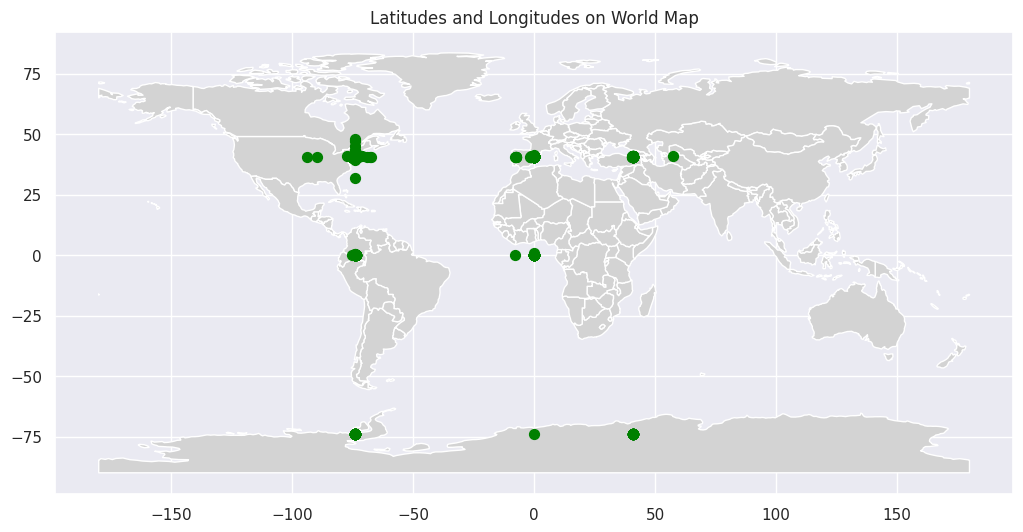

In [24]:
import geopandas as gpd
from shapely.geometry import Point

longitudes, latitudes = list(df['pickup_longitude']), list(df['pickup_latitude'])
latitudes = list(filter(lambda lat: -90 <= lat <= 90, latitudes))
longitudes = list(filter(lambda lon: -180 <= lon <= 180, longitudes))

geometry = [Point(xy) for xy in zip(longitudes, latitudes)]
geo_df = gpd.GeoDataFrame(geometry=geometry)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(15, 6))
world.plot(ax=ax, color='lightgray')
geo_df.plot(ax=ax, color='green', markersize=50)

plt.title('Latitudes and Longitudes on World Map')
plt.show()

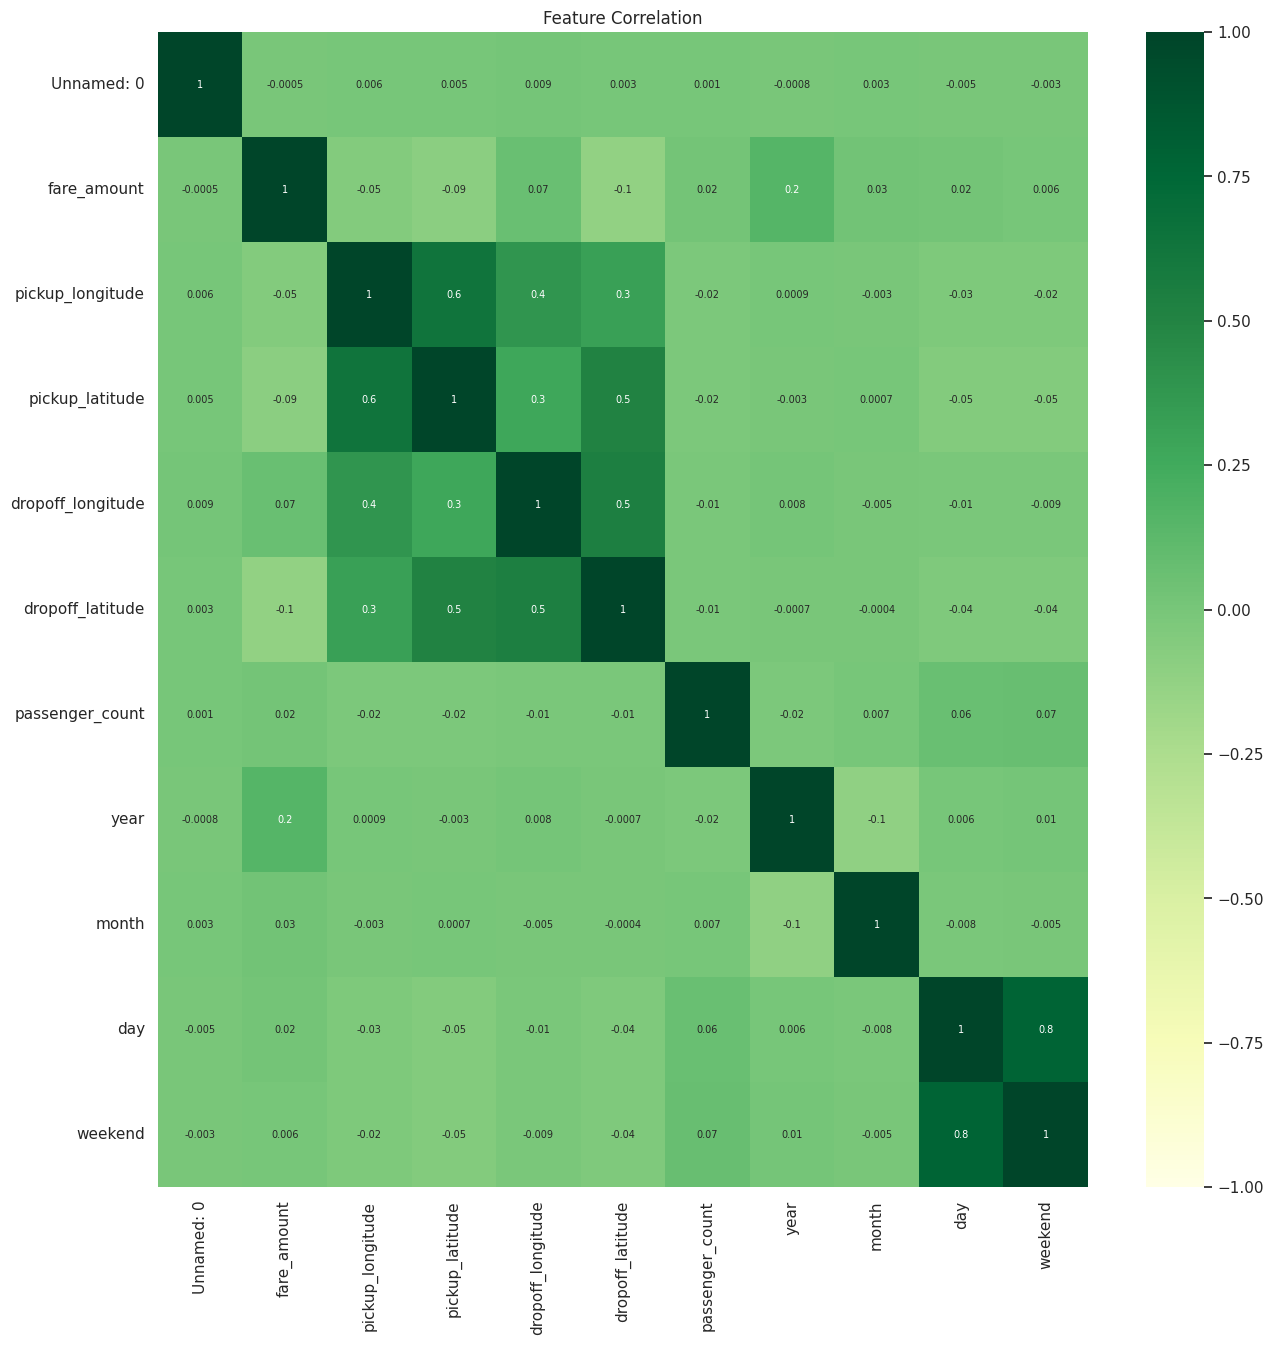

In [18]:
def preproc(df:pd.DataFrame)->pd.DataFrame:
    df = df.copy()
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df['year'] = df['pickup_datetime'].dt.year
    df['month'] = df['pickup_datetime'].dt.month
    df['day'] = df['pickup_datetime'].dt.dayofweek
    df['weekend'] = (df['day'] >= 5).astype(int)
    return df

df = preproc(df)
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', bool]
plt.figure(figsize=(15, 15))
sns.heatmap(df.select_dtypes(include=numerics).corr(), cmap=SNS_CMAP, annot=True, annot_kws={'fontsize':7}, fmt='.1g', vmin=-1, vmax=1, center= 0)
plt.title("Feature Correlation")
plt.show()

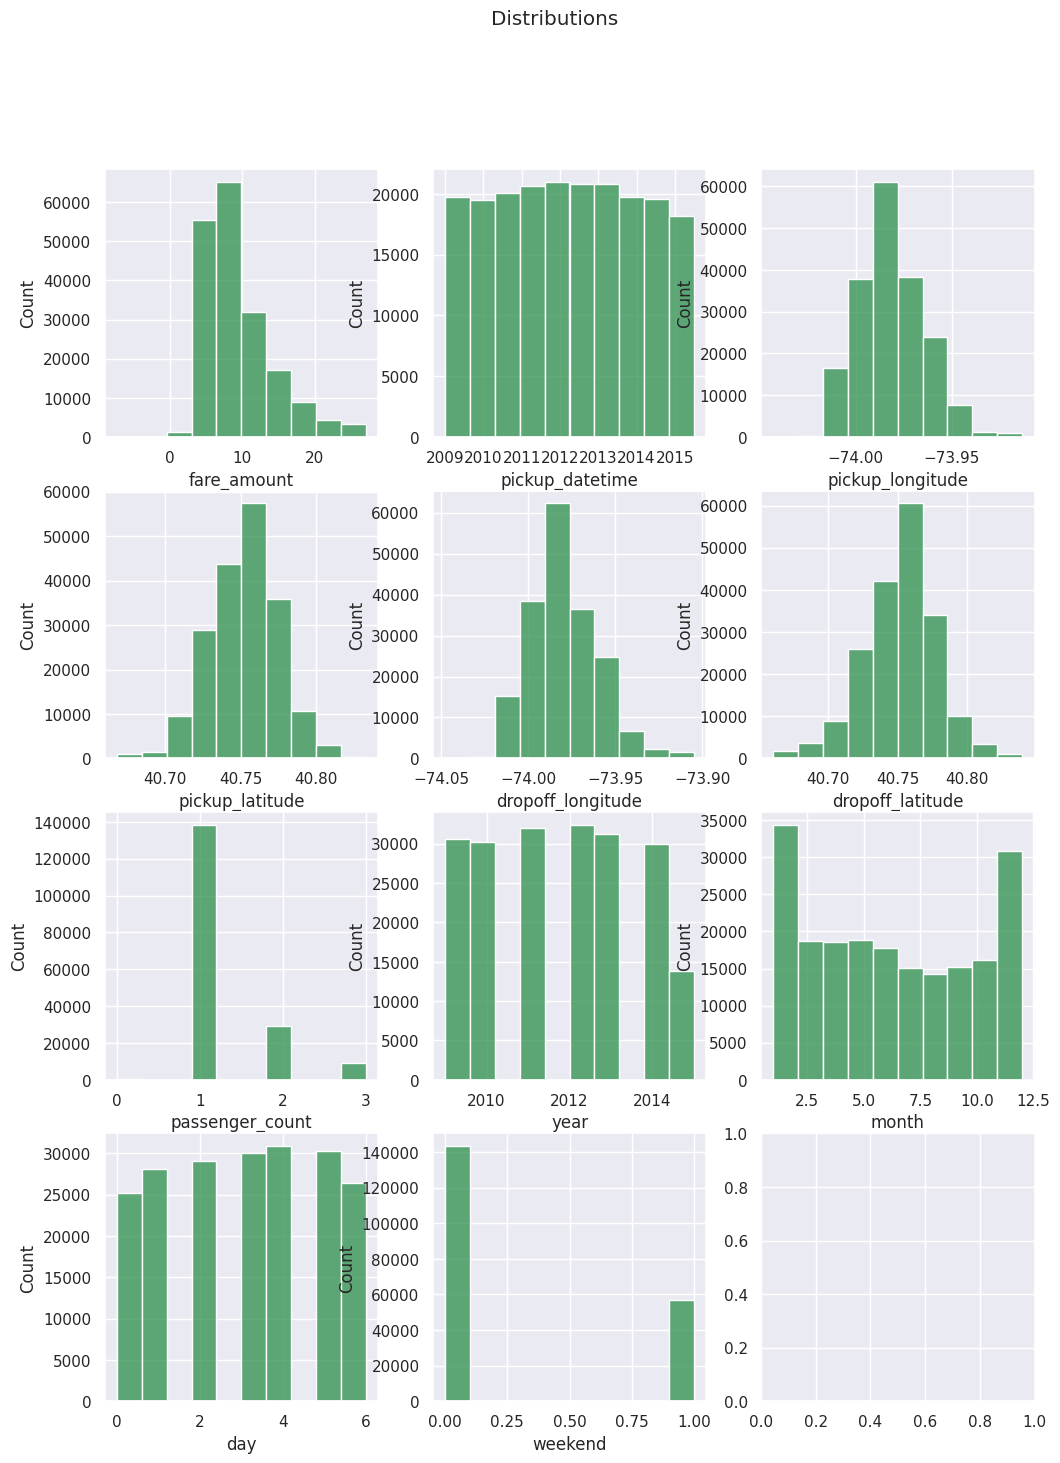

In [7]:
from typing import List

def removeOutliers(df):
    Q1 = df.quantile(0.2)
    Q3 = df.quantile(0.8)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df >= lower_bound) & (df <= upper_bound)]

def plot_histograms_binary(df: pd.DataFrame, cols:List[str]=None, target: str = "TARGET", ncols: int = 3)->None:
    """
    Plot a series of histograms for a binary target
    
    Parameters: 
        df (Dataframe) : data to be visualized
        *params : any
    """
    df['binned_target'] = pd.cut(df[TARGET], bins=5)
    if cols is None:
        cols = df.columns
    nrows = (len(cols)+ncols-1)//ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    for i, col in enumerate(cols):
        data = removeOutliers(df[col])
        sns.histplot(data=data, bins=10, ax=axes.flatten()[i], color=colors[4])
    fig.suptitle('Distributions')
    plt.show()
    
cols = ['fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'year', 'month', 'day',
       'weekend']
plot_histograms_binary(df, cols, TARGET)

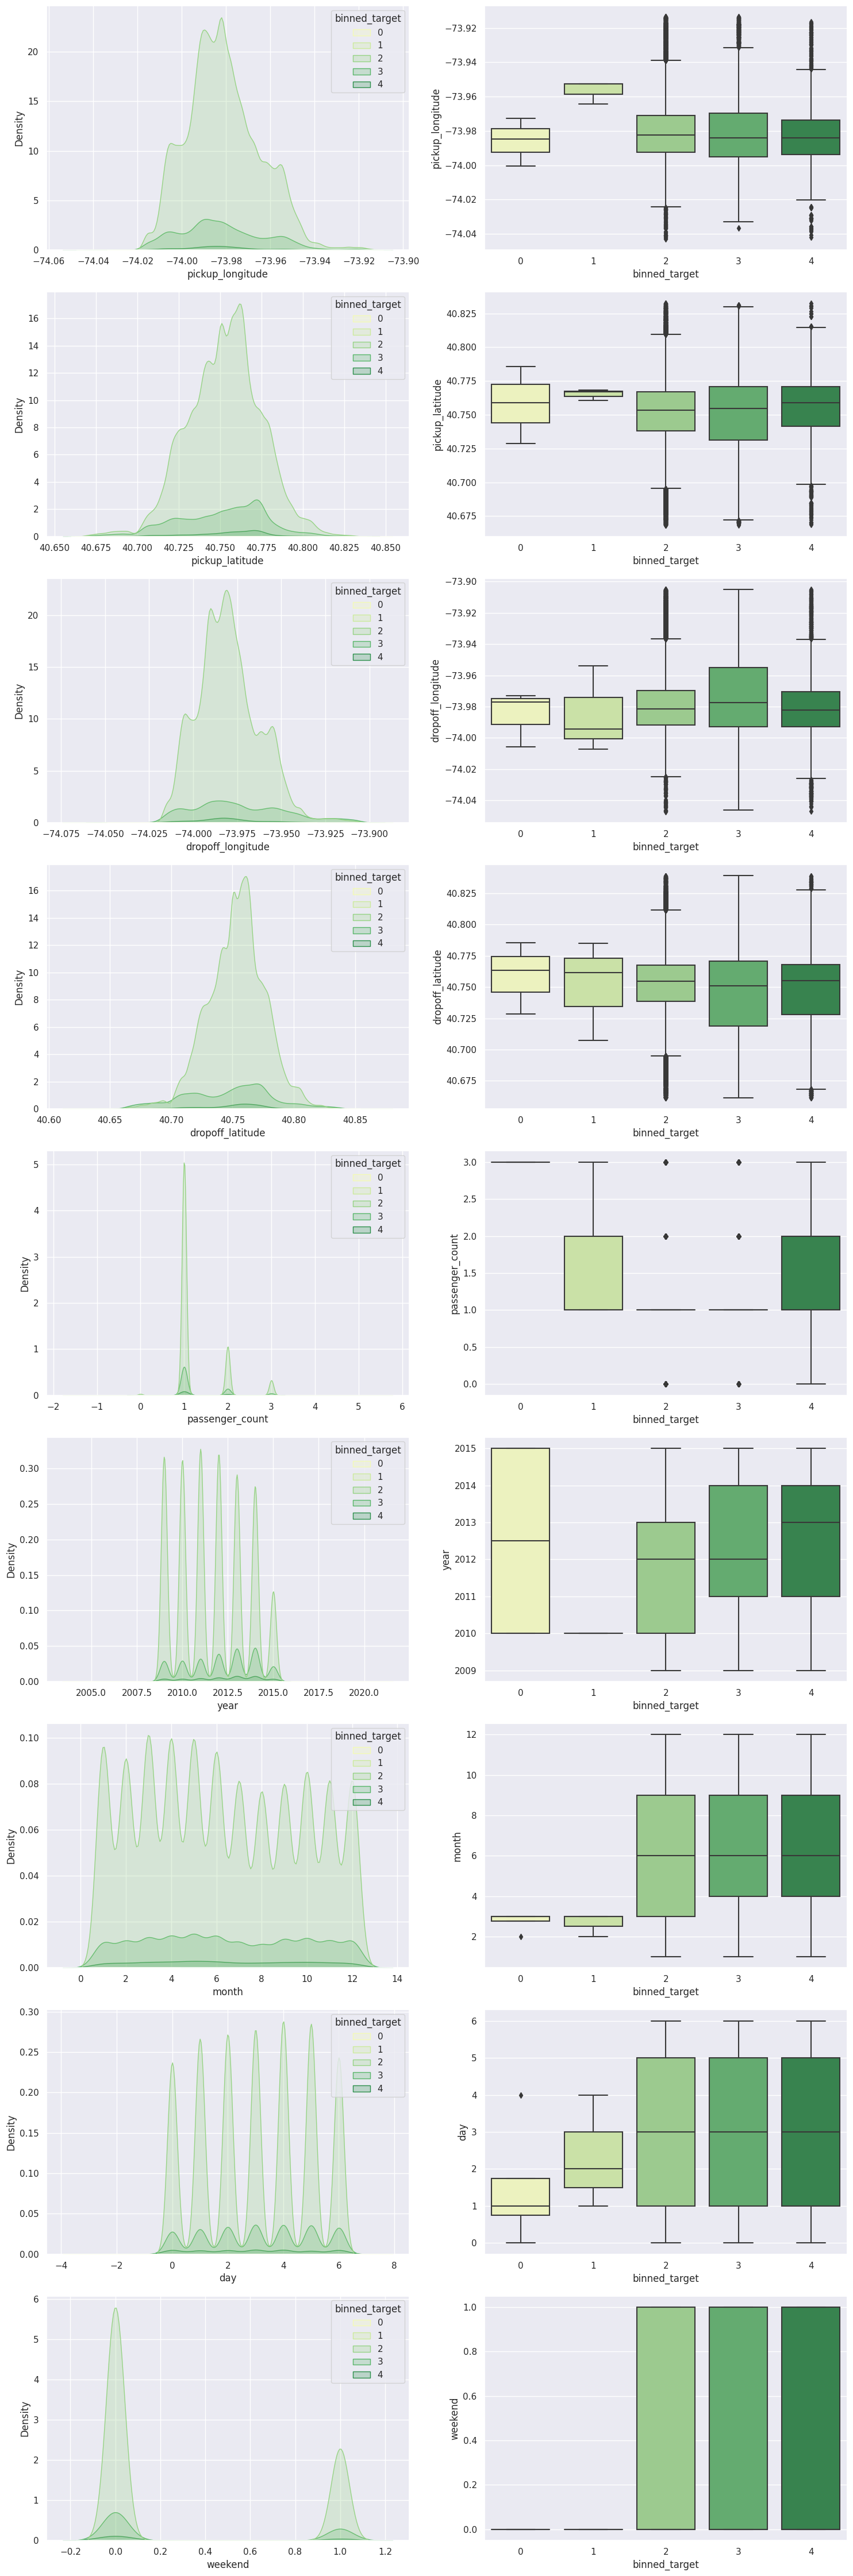

In [32]:
def plot_continous_distributions(df, target, filter_outliers = True, cols=None):
    df = df.copy()[df[target]<60]
    df['binned_target'] = pd.cut(df[TARGET], bins=5, labels=[0, 1, 2, 3, 4])
    cols = [col for col in cols if col is not target]
    target = 'binned_target'
    
    if cols is None:
        cols = [col for col in df.columns if len(df[col].unique())>10]
    fig,axes = plt.subplots(len(cols), 2,figsize=(15, 5*len(cols)))

    for i, col in enumerate(cols):
        if filter_outliers:
            Q1, Q3 = df[col].quantile(0.2), df[col].quantile(0.8)
            IQR = Q3 - Q1
            lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
            filtered_df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        else:
            filtered_df = df
        sns.kdeplot(data = filtered_df, x=col, hue=df[target], fill=True, ax=axes[i][0])
        sns.boxplot(filtered_df, y=col, x=target, ax=axes[i][1])
    fig.tight_layout()
    plt.show()
    
plot_continous_distributions(df, TARGET, True, cols)

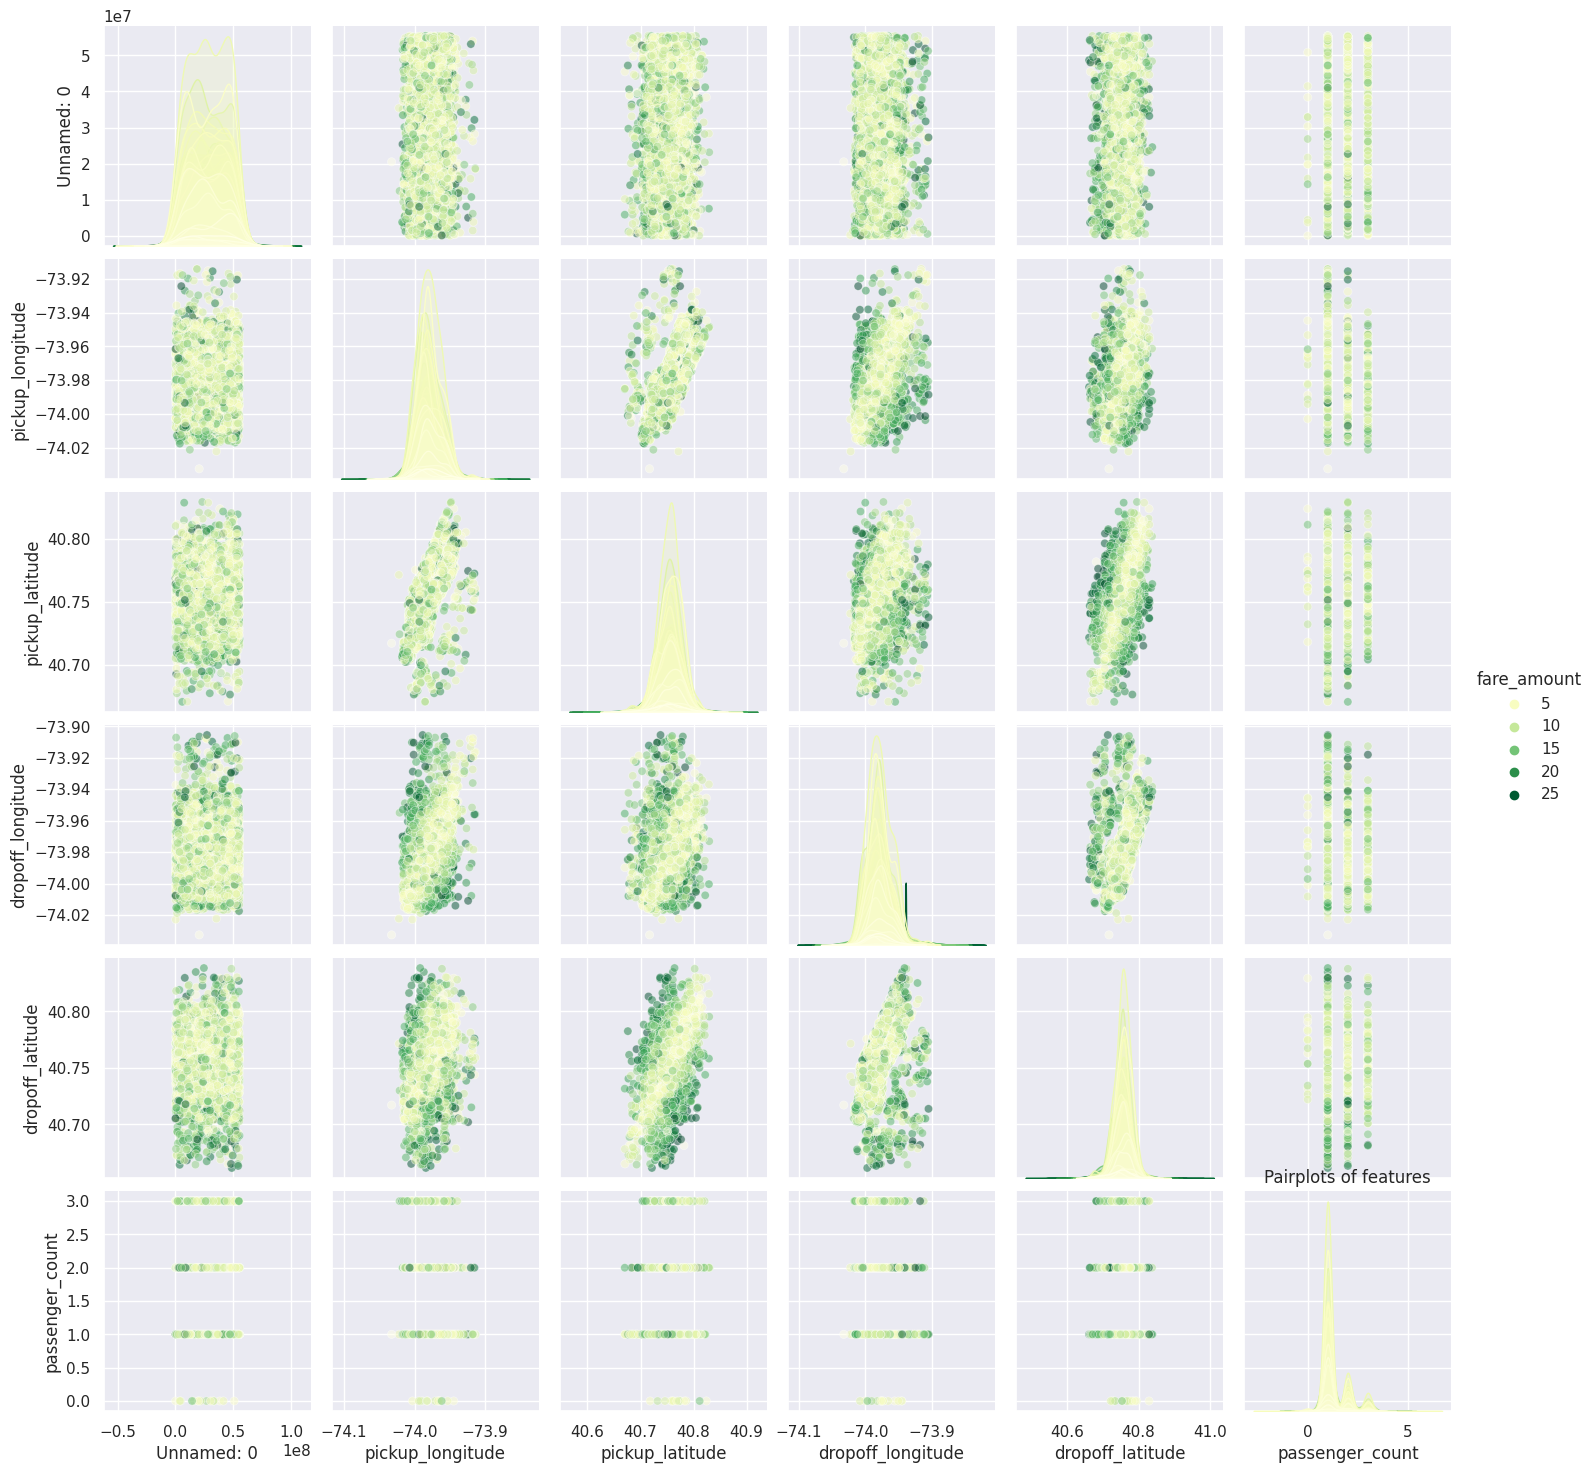

In [17]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
sns.pairplot(df.select_dtypes(include=numerics).sample(5000), hue=TARGET, plot_kws={'alpha': 0.5}, palette=SNS_CMAP)
plt.title('Pairplots of features')
plt.show()

# <div style="width: 100%"><h1 style="text-align: center; font-family: 'Roboto', sans-serif; color: rgb(204, 234, 156); background-color: rgba(4, 107, 56, 0.8); padding: 30px; border: 5px solid rgb(204, 234, 156); border-style: solid; border-radius: 10px;"> Preprocessing </h1></div>

In [4]:
base_path = kagglehub.dataset_download('yasserh/uber-fares-dataset', path='uber.csv')
df = pd.read_csv(base_path)

<h3 style="text-align: center; font-family: 'Roboto', sans-serif; color: rgba(43, 143, 74, 1.0); background-color: rgba(243, 250, 182, 0.3); padding: 10px; border-style: solid; border-radius: 10px;"> Feature Engineering </h3>

<div style="margin: 0% 15%; text-align: center; font-family: 'Roboto', sans-serif; background-color: rgba(43, 143, 74, 0.15); padding: 20px; border-style: solid; border-radius: 10px;">
    <h3>Haversine Formula</h3>
    <p>
        The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes.
    </p>
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/cb/Illustration_of_great-circle_distance.svg/330px-Illustration_of_great-circle_distance.svg.png" alt="Haversine formula illustration"/>
    <p><br>
        The haversine formula allows the haversine of θ to be computed directly from the latitude (represented by φ) and longitude (represented by λ) of the two points:
    </p>
    <p>
        hav(θ) = hav(Δφ) + cos(φ<sub>1</sub>)cos(φ<sub>2</sub>)hav(Δλ)
    </p>
</div>

In [5]:
def haversine_distance(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    """
    Calculate the great-circle distance between two points on the Earth's surface
    given their latitude and longitude using the Haversine formula.

    Parameters:
    ----------
        lat1, lon1, lat2, lon2: float
            Latitude and Longitude of Source and Destination
            
    Returns:
    ----------
        distance: float
    """
    R = 6371.0 
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = R * c
    return distance

In [6]:
def preproc(df: pd.DataFrame) -> pd.DataFrame:
    
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df['year'] = df['pickup_datetime'].dt.year
    df['month'] = df['pickup_datetime'].dt.month
    df['day'] = df['pickup_datetime'].dt.dayofweek
    df['weekend'] = (df['day'] >= 5).astype(int)
    
    df['distance'] = df.apply(lambda x: haversine_distance(x['pickup_latitude'], x['pickup_longitude'],
                                                           x['dropoff_latitude'], x['dropoff_longitude']), 
                              axis=1)
    return df

<h3 style="text-align: center; font-family: 'Roboto', sans-serif; color: rgba(43, 143, 74, 1.0); background-color: rgba(243, 250, 182, 0.3); padding: 10px; border-style: solid; border-radius: 10px;"> Outlier Culling </h3>

In [7]:
def outlier_removal(df:pd.DataFrame, cols: List[str] = None)->pd.DataFrame:
    mask = pd.Series([True] * len(df))
    if cols is None:
        cols = df.columns
    for col in cols:
        Q1 = df[col].quantile(0.2)
        Q3 = df[col].quantile(0.8)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        mask &= (df[col] >= lower_bound) & (df[col] <= upper_bound)
        
    return df[mask]

cols = ['fare_amount', 'pickup_longitude', 'pickup_latitude',
        'dropoff_longitude','dropoff_latitude', 'passenger_count']
df = outlier_removal(df, cols)

<h3 style="text-align: center; font-family: 'Roboto', sans-serif; color: rgba(43, 143, 74, 1.0); background-color: rgba(243, 250, 182, 0.3); padding: 10px; border-style: solid; border-radius: 10px;"> Pipeline </h3>

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder

In [9]:
cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'year', 'month',
       'weekend', 'distance', ]
ohe_cols = ['day',]

preprocessor = preprocessor = Pipeline(steps=[
    ('feat_eng', FunctionTransformer(preproc)),
    ('encoder-scalar', ColumnTransformer([
        ('encoder', OneHotEncoder(), ohe_cols),
        ('scalar', RobustScaler(), cols),
    ])),
    ('imputer', SimpleImputer()),
])

preprocessor.fit(df)

Pipeline(steps=[('feat_eng',
                 FunctionTransformer(func=<function preproc at 0x7e27f2e47f40>)),
                ('encoder-scalar',
                 ColumnTransformer(transformers=[('encoder', OneHotEncoder(),
                                                  ['day']),
                                                 ('scalar', RobustScaler(),
                                                  ['pickup_longitude',
                                                   'pickup_latitude',
                                                   'dropoff_longitude',
                                                   'dropoff_latitude',
                                                   'passenger_count', 'year',
                                                   'month', 'weekend',
                                                   'distance'])])),
                ('imputer', SimpleImputer())])

In [11]:
X = preprocessor.transform(df)
Y = df[TARGET]
X.shape, Y.shape

((157713, 16), (157713,))

# <div style="width: 100%"><h1 style="text-align: center; font-family: 'Roboto', sans-serif; color: rgb(204, 234, 156); background-color: rgba(4, 107, 56, 0.8); padding: 30px; border: 5px solid rgb(204, 234, 156); border-style: solid; border-radius: 10px;"> Baseline Models </h1></div>

In [12]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
import time

In [13]:
import torch
if torch.cuda.is_available():
    from cuml.svm import SVR
else:
    from sklearn.svm import SVR

In [14]:
def regression_metrics_cv(model, X, y, cv=5):
    """
    Perform cross-validation on the given regression model and compute MSE, RMSE, and R².

    Args:
        model: A regression model (e.g., LinearRegression, Ridge, etc.).
        X: Feature matrix.
        y: Target variable.
        cv: Number of cross-validation folds (default=5).

    Returns:
        tuple: Cross-validated MSE, RMSE, and R² scores.
    """
    mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    scores = cross_validate(
        model, X, y,
        scoring={'mse': mse_scorer, 'r2': 'r2', 'mae': mae_scorer},
        cv=cv,
        return_train_score=False
    )
    mse_scores = np.mean(abs(scores['test_mse']) )
    rmse_scores = np.mean(np.sqrt(mse_scores))
    r2_scores = np.mean(scores['test_r2'])
    mae_scores = np.mean(abs(scores['test_mae']))

    return mse_scores, rmse_scores, r2_scores, mae_scores

def clrd(text: str, color: str = None):
    text = str(text)
    color_codes = {
        'ok': '\033[92m',        # Green
        'error': '\033[91m',     # Red
        'warning': '\033[93m',   # Yellow
        'success': '\033[92m',   # Green
        'status': '\033[95m',    # Magenta
        'special': '\033[94m',   # Blue
        'log': '\033[96m',       # Cyan
        'reset': '\033[0m'       # Reset to default color
    }
    color_code = color_codes.get(color, color_codes['reset'])
    return f"{color_code}{text}{color_codes['reset']}"

def print_res(model, X, Y):
    model.fit(X, Y)
    pred = model.predict(X_Test)
    mse, rmse, r2, mae = regression_metrics_cv(model, X, Y)
    print(f"RMSE: {rmse:.4f}   MAE: {mae:.4f}   R²: {r2:.4f}   MSE: {mse:.4f}")
    print('='*50)

In [15]:
def build_and_evaluate_regression_models(X, Y):
    models = [LinearRegression, Ridge, RandomForestRegressor, GradientBoostingRegressor, MLPRegressor, XGBRegressor, CatBoostRegressor, LGBMRegressor,]
    model_names = ['LinearRegression', 'Ridge', 'RandomForestRegressor', 'GradientBoostingRegressor', 'MLPRegressor', 'XGBRegressor', 'CatBoostRegressor', 'LGBMRegressor',]

    for model, model_name in zip(models, model_names):
        print('='*50)
        print(clrd(model_name, 'status'))
        try:
            if model_name=='LGBMRegressor':
                regressor_model = model(verbosity=-1)
            elif model_name=='CatBoostRegressor':
                regressor_model = model(verbose=False)
            elif model_name=='XGBRegressor':
                regressor_model = model(verbose=0)
            else:
                regressor_model = model()

            START = time.time()
            mse, rmse, r2, mae = regression_metrics_cv(regressor_model, X, Y)
            END = time.time()
            print("Ran in ", clrd(END-START, 'log'), " seconds")            
            print(f"RMSE: {rmse:.4f}   MAE: {mae:.4f}   R²: {r2:.4f}   MSE: {mse:.4f}")
        except:
            print(clrd('Error training model', 'error'))
        print('='*50)
        
build_and_evaluate_regression_models(X, Y)

LinearRegression
Ran in  0.9045252799987793  seconds
RMSE: 2.3587   MAE: 1.6342   R²: 0.7181   MSE: 5.5634
Ridge
Ran in  0.38814735412597656  seconds
RMSE: 2.3587   MAE: 1.6342   R²: 0.7181   MSE: 5.5634
RandomForestRegressor
Ran in  659.9256327152252  seconds
RMSE: 2.1274   MAE: 1.4416   R²: 0.7707   MSE: 4.5260
GradientBoostingRegressor
Ran in  213.04557156562805  seconds
RMSE: 2.1953   MAE: 1.5027   R²: 0.7558   MSE: 4.8195
MLPRegressor
Ran in  883.7399024963379  seconds
RMSE: 2.0526   MAE: 1.3631   R²: 0.7865   MSE: 4.2132
XGBRegressor
Ran in  5.005185127258301  seconds
RMSE: 2.0440   MAE: 1.3592   R²: 0.7883   MSE: 4.1779
CatBoostRegressor
Ran in  74.02755308151245  seconds
RMSE: 2.0155   MAE: 1.3373   R²: 0.7942   MSE: 4.0623
LGBMRegressor
Ran in  11.488945722579956  seconds
RMSE: 2.0915   MAE: 1.4147   R²: 0.7784   MSE: 4.3742
